# VQ-VAE-transformer Demo

Image generation using VQ-VAE requires sampling an generative model (e.g. PixelCNN) in the discretized latent space. A recent work (https://arxiv.org/abs/2012.09841) replaced PixelCNN with transformer and showed impressive results. This notebook contains a simple implementation of the VQ-VAE-transformer model for conditional image generation with mnist dataset.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, MaxPool2D, MultiHeadAttention, BatchNormalization, Activation, Dense

In [2]:
# data prep.
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("Train images:", x_train.shape)
print("Train labels:", y_train.shape)

Train images: (60000, 28, 28, 1)
Train labels: (60000,)


In [3]:
# ref: https://github.com/HenningBuhl/VQ-VAE_Keras_Implementation/blob/master/VQ_VAE_Keras_MNIST_Example.ipynb
class VQVAELayer(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_embeddings=8, commitment_cost=0.25,
                 initializer='uniform', epsilon=1e-10, name='vqvae', **kwargs):
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        self.initializer = initializer
        super(VQVAELayer, self).__init__(**kwargs)
        
    def get_config(self):
        cfg = super().get_config()
        return cfg   
    
    def build(self, input_shape):
        # Add embedding weights.
        self.w = self.add_weight(name='embedding',
                                 shape=(self.embedding_dim, self.num_embeddings),
                                 initializer=self.initializer,
                                 trainable=True)

        # Finalize building.
        super(VQVAELayer, self).build(input_shape)

    def call(self, x):
        # Flatten input except for last dimension.
        flat_inputs = tf.reshape(x, (-1, self.embedding_dim))

        # Calculate distances of input to embedding vectors.
        distances = (tf.reduce_sum(flat_inputs**2, axis=1, keepdims=True)
                     - 2 * tf.matmul(flat_inputs, self.w)
                     + tf.reduce_sum(self.w ** 2, axis=0, keepdims=True))

        # Retrieve encoding indices.
        encoding_indices = tf.argmax(-distances, axis=1)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        encoding_indices = tf.reshape(encoding_indices, tf.shape(x)[:-1])
        quantized = self.quantize(encoding_indices)
        
        return quantized, encoding_indices

    @property
    def embeddings(self):
        return self.w

    def quantize(self, encoding_indices):
        w = tf.transpose(self.embeddings.read_value())
        return tf.nn.embedding_lookup(w, encoding_indices)

In [18]:
class VQVAE(tf.keras.models.Model):

    def __init__(self, embedding_dim, vocabulary_size):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.vocabulary_size = vocabulary_size
        self.enc = Sequential([Conv2D(32, 3, padding='same', strides=2, activation='relu'),
                               Conv2D(64, 3, padding='same',  strides=2, activation='relu'),
                               Conv2D(self.embedding_dim, 3, padding='same', activation='relu')])
        
        self.dec = Sequential([Conv2DTranspose(64, 3, strides=(2, 2), padding='same', activation='relu'),
                               Conv2DTranspose(32, 3, strides=(2, 2), padding='same', activation='relu'),
                               Conv2DTranspose(1, 1, strides=(1, 1), activation='sigmoid', padding='same', name='output')])
        
        self.vq = VQVAELayer(embedding_dim, num_embeddings=self.vocabulary_size)
        
    def recons_loss(self, true, pred):
        return tf.reduce_mean((true - pred)**2)

    def call(self, inputs):
        z_e = self.enc(inputs)
        z_q, encoding_indices = self.vq(z_e)
        x = self.dec(z_q)
        return x, encoding_indices
    
    def train_step(self, inputs):
        train_vars = self.trainable_variables
        with tf.GradientTape() as tape:
            z_e = self.enc(inputs)
            z_q, encoding_indices = self.vq(z_e)
            straight_through = tf.keras.layers.Lambda(lambda x : x[0] + tf.stop_gradient(x[1] - x[0]))
            
            x = straight_through([z_e, z_q])
            x = self.dec(x)
            
            vq_loss = tf.reduce_mean((tf.stop_gradient(z_e) - z_q)**2)
            commit_loss = tf.reduce_mean((z_e - tf.stop_gradient(z_q))**2)

            latent_loss = vq_loss + 0.25 * commit_loss
            recons_loss = self.recons_loss(inputs, x)
            
            loss = recons_loss + latent_loss 

        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        
        return {'recons_loss': recons_loss, 'latent_loss':latent_loss}
    
    def test_step(self, inputs):
        
        z_e = self.enc(inputs)
        z_q, encoding_indices = self.vq(z_e)
        x = self.dec(z_q)
        
        vq_loss = tf.reduce_mean((tf.stop_gradient(z_e) - z_q)**2)
        commit_loss = tf.reduce_mean((z_e - tf.stop_gradient(z_q))**2)
        latent_loss = vq_loss + 0.25 * commit_loss
        recons_loss = self.recons_loss(inputs, x)

        loss = recons_loss + latent_loss 

        return {'recons_loss': recons_loss, 'latent_loss':latent_loss}

In [19]:
embedding_dim = 128
vocabulary_size = 8
model = VQVAE(embedding_dim, vocabulary_size)
model.compile(optimizer='adam')
model.build((None, x_train.shape[1], x_train.shape[2], 1))
model.summary()

Model: "vqvae_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_10 (Sequential)   (None, 7, 7, 128)         92672     
_________________________________________________________________
sequential_11 (Sequential)   (None, 28, 28, 1)         92289     
_________________________________________________________________
vqvae_layer_1 (VQVAELayer)   multiple                  1024      
Total params: 185,985
Trainable params: 185,985
Non-trainable params: 0
_________________________________________________________________


In [6]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_recons_loss', 
                                                           min_delta=0, 
                                                           patience=10,
                                                           restore_best_weights=True)
model.fit(x_train,
          validation_data=(x_test, None),
          batch_size=256, 
          epochs=60, 
          callbacks=[early_stopping_callback])

Epoch 1/60
235/235 [==============================] - 13s 45ms/step - recons_loss: 0.0673 - latent_loss: 0.9395 - val_recons_loss: 0.0377 - val_latent_loss: 4.0367
Epoch 2/60
235/235 [==============================] - 9s 39ms/step - recons_loss: 0.0276 - latent_loss: 0.9178 - val_recons_loss: 0.0223 - val_latent_loss: 0.3604
Epoch 3/60
235/235 [==============================] - 9s 39ms/step - recons_loss: 0.0214 - latent_loss: 0.1498 - val_recons_loss: 0.0186 - val_latent_loss: 0.1263
Epoch 4/60
235/235 [==============================] - 9s 39ms/step - recons_loss: 0.0174 - latent_loss: 0.0917 - val_recons_loss: 0.0165 - val_latent_loss: 0.1020
Epoch 5/60
235/235 [==============================] - 9s 39ms/step - recons_loss: 0.0165 - latent_loss: 0.0777 - val_recons_loss: 0.0152 - val_latent_loss: 0.0851
Epoch 6/60
235/235 [==============================] - 9s 39ms/step - recons_loss: 0.0163 - latent_loss: 0.0793 - val_recons_loss: 0.0162 - val_latent_loss: 0.0944
Epoch 7/60
235/235 [=

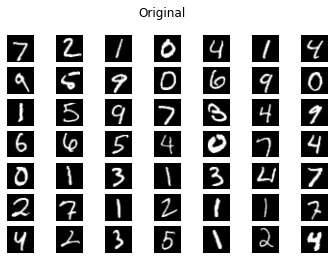

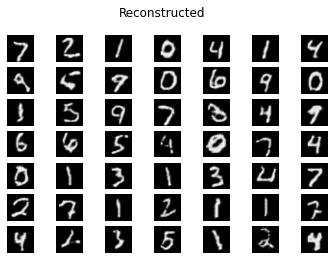

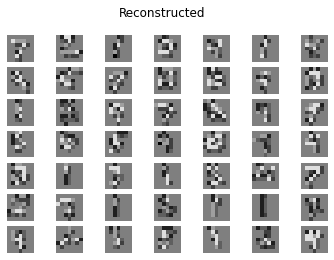

In [16]:
def img_grid(imgs, rows, cols, title):
    fig = plt.figure()
    for i, j in np.ndindex(rows, cols):
        plt.subplot(rows, cols, i*rows+j+1)
        plt.imshow(np.repeat(imgs[i*rows+j], 3, -1))
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

cols = 7
rows = 7
inp_x = x_test[:cols*rows]
pred_x, ebd = model.predict(inp_x)
img_grid(inp_x, rows, cols, 'Original')
img_grid(pred_x, rows, cols, 'Reconstructed')
img_grid(ebd[...,np.newaxis]/8, rows, cols, 'Reconstructed')

In [8]:
# get encoding_indices of training images
batch = 256
results = []
for i in range(0, x_train.shape[0], batch):
    x = x_train[i:i+batch]
    out = model.predict(x)
    results.append(out[1])
results = np.concatenate(results, 0)

train_seq = np.eye(8)[results.reshape(-1, 49)]
train_seq_pad = np.zeros((60000,50,8))
train_seq_pad[:, 1:] = train_seq

train_label = np.eye(10)[y_train]
train_label = np.repeat(train_label[:, np.newaxis], 50, 1)

train_inp = np.concatenate([train_seq_pad, train_label], -1)

print (train_seq_pad.shape, train_label.shape, train_inp.shape)

(60000, 50, 8) (60000, 50, 10) (60000, 50, 18)


In [9]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)


def create_look_ahead_mask(size):
    mask =  tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

def top_p_filter(l, thres=0.80):
    sorted_idx = np.argsort(l).tolist()
    idx = sorted_idx.pop()
    psum = l[idx]
    output = [idx]
    while 1:
        idx = sorted_idx.pop()
        p = l[idx]
        psum += p
        if psum > thres:
            break
        output.append(idx)
    return output

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha = MultiHeadAttention(num_heads, d_model)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, look_ahead_mask,  training=True):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1 = self.mha(x, x, attention_mask=look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out = self.layernorm1(attn1 + x)

        ffn_output = self.ffn(out)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out = self.layernorm2(ffn_output + out)  # (batch_size, target_seq_len, d_model)

        return out

class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, maximum_position_encoding=50, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = Dense(d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, look_ahead_mask, training=True):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.dec_layers[i](x, look_ahead_mask, training)
        return x
    
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, vocabulary_size, seq_len=50, rate=0.1):
        super(Transformer, self).__init__()
        
        self.decoder = Decoder(num_layers, d_model, num_heads, dff)
        self.mask = create_look_ahead_mask(seq_len+1)
        self.final_layer = tf.keras.layers.Dense(vocabulary_size, activation='softmax')
        
    def call(self, inp, training):
        
        dec_output = self.decoder(inp, self.mask, training)
        final_output = self.final_layer(dec_output)[:, :49] # (batch_size, tar_seq_len, target_vocab_size)

        return final_output

In [10]:
num_layers = 8
d_model = 32
num_heads = 8
dff = 32

tsfm = Transformer(num_layers, d_model, num_heads, dff, vocabulary_size)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.98,epsilon=1e-9)
tsfm.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [11]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                           min_delta=0, 
                                                           patience=5,
                                                           restore_best_weights=True)
tsfm.fit(train_inp, 
         train_seq, 
         validation_split=0.1, 
         batch_size=256, 
         epochs=500,
         callbacks=[early_stopping_callback])

Epoch 1/500
(None, 50, 32)
(None, 50, 32)
211/211 [==============================] - 70s 302ms/step - loss: 1.4577 - val_loss: 1.0595
Epoch 2/500
211/211 [==============================] - 63s 298ms/step - loss: 1.0837 - val_loss: 0.9278
Epoch 3/500
211/211 [==============================] - 63s 298ms/step - loss: 0.9841 - val_loss: 0.8396
Epoch 4/500
211/211 [==============================] - 63s 300ms/step - loss: 0.9087 - val_loss: 0.7815
Epoch 5/500
211/211 [==============================] - 63s 298ms/step - loss: 0.8560 - val_loss: 0.7435
Epoch 6/500
211/211 [==============================] - 63s 298ms/step - loss: 0.8171 - val_loss: 0.7163
Epoch 7/500
211/211 [==============================] - 63s 298ms/step - loss: 0.7880 - val_loss: 0.6961
Epoch 8/500
211/211 [==============================] - 63s 298ms/step - loss: 0.7649 - val_loss: 0.6808
Epoch 9/500
211/211 [==============================] - 63s 299ms/step - loss: 0.7469 - val_loss: 0.6671
Epoch 10/500
211/211 [============

KeyboardInterrupt: 

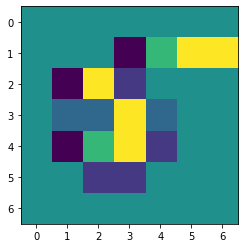

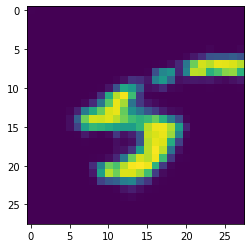

In [15]:
r = np.zeros((1, 50), dtype=int)
c = np.ones_like(r) * 5
r = np.eye(8)[r]
c = np.eye(10)[c] 
r[:, 0, :8] = 0
inp = np.concatenate([r, c], -1)

for i in range(49):
    out = tsfm.predict(inp)
    out = out[0, i]
    out = top_p_filter(out)
    idx = np.random.choice(out)
    inp[:, i+1, :8] = np.eye(8)[idx]
    
out = inp[0, 1:, :8]
encoding_indices = np.argmax(out, -1)
plt.imshow(encoding_indices.reshape(7, 7))
plt.show()

dec_inp = tf.gather(model.vq.embeddings, tf.cast(encoding_indices,tf.int64), axis=1)
dec_inp = tf.transpose(dec_inp)
out = model.dec(tf.reshape(dec_inp[tf.newaxis], (1, 7, 7, 128)))
plt.imshow(out[0,:,:,0])
plt.show()